In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features

sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

In [4]:
egresos_torax = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")
egresos_torax["FECHA_EGRESO"] = pd.to_datetime(
    egresos_torax["ANO_EGRESO"].astype(str)
    + "-"
    + egresos_torax["MES_EGRESO"].astype(str)
    + "-"
    + egresos_torax["DIA_EGRESO"].astype(str),
    format="%Y-%m-%d",
)

# dias_estada_grd = pd.read_excel("../data/processed/dias_estada_hospitalizados.xlsx")

canasta_hospitalizados_grd = pd.read_excel(
    "../data/processed/canasta_procedimientos_hospitalizados.xlsx"
)

Primero se quiere hacer un forecasting total de los egresos (sin desglose por diagnostico),
y tambien de los procedimientos necesarios totales


In [5]:
DIAGNOSTICO = "C341"

In [6]:
resumen_egresos_totales = (
    egresos_torax.query("DIAG1 == @DIAGNOSTICO and ANO_EGRESO == 2019")
    .groupby(["ANO_EGRESO"])["n_egresos"]
    .sum()
    .reset_index()
)
resumen_procedimientos_totales = canasta_hospitalizados_grd.query(
    "DIAGNOSTICO1 == 'C34.1' and ANIO_EGRESO == 2019"
)

In [7]:
EGRESOS_AUMENTADOS = 300
EGRESOS_2019 = resumen_egresos_totales.n_egresos.iloc[0]
AUMENTO_PROPORCIONAL = EGRESOS_AUMENTADOS / EGRESOS_2019

In [8]:
procedimientos_aumentados = resumen_procedimientos_totales.copy()
COLS_A_AUMENTAR = ["cantidad_procedimientos", "cantidad_pacientes_distintos"]

procedimientos_aumentados[COLS_A_AUMENTAR] = (
    procedimientos_aumentados[COLS_A_AUMENTAR] * AUMENTO_PROPORCIONAL
)

# 1. Forecasting

En este cuadernilllo se quiere predecir la cantidad de egresos hospitalarios que tendra
el Hospital del Torax a lo largo del tiempo. Ademas, se quire saber cuantos insumos se necesitaran
para atender tales casos.


In [9]:
resumen_egresos = egresos_torax.groupby(egresos_torax["FECHA_EGRESO"])["n_egresos"].sum().to_frame()

<Axes: xlabel='FECHA_EGRESO'>

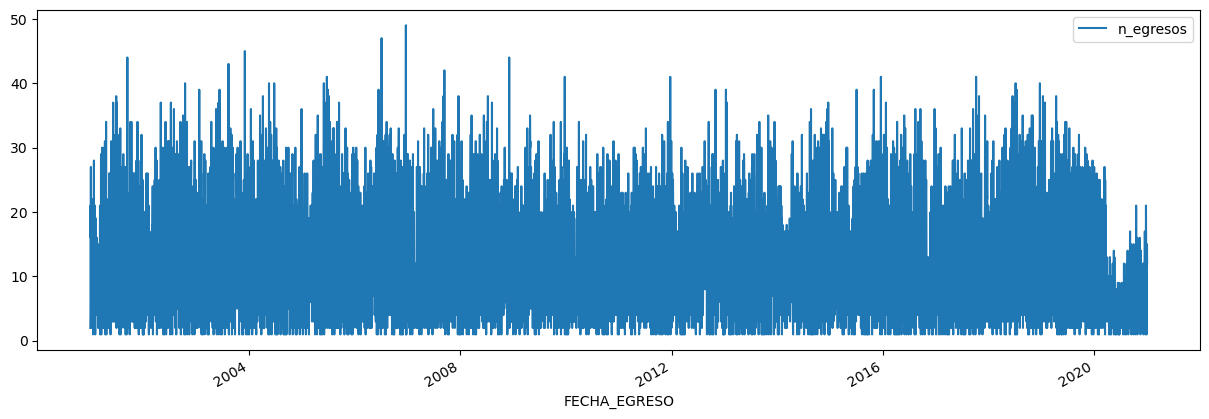

In [10]:
resumen_egresos.plot(figsize=(15, 5))

## Separacion en Train/Test


In [11]:
train = resumen_egresos[resumen_egresos.index < "01-01-2017"]
test = resumen_egresos[resumen_egresos.index >= "01-01-2017"]

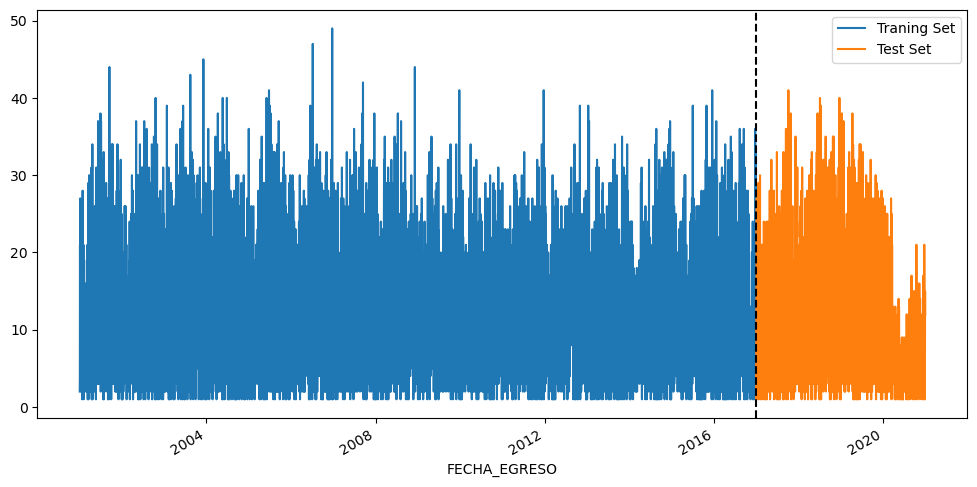

In [12]:
fig, axis = plt.subplots(1, 1, figsize=(12, 6))
train.plot(ax=axis, label="Traning")
test.plot(ax=axis, label="Test")
axis.axvline("01-01-2017", color="black", ls="--")
axis.legend(["Traning Set", "Test Set"])

In [13]:
resumen_egresos = build_features.create_features_datetime_index(resumen_egresos)

In [14]:
resumen_egresos

,n_egresos,dayofweek,quarter,month,year,dayofyear,lag_1_anio,lag_2_anios,lag_3_anios
FECHA_EGRESO,,,,,,,,,
2001-01-01,2,0,1,1,2001,1,NaN,NaN,NaN
2001-01-02,4,1,1,1,2001,2,NaN,NaN,NaN
2001-01-03,21,2,1,1,2001,3,NaN,NaN,NaN
2001-01-04,16,3,1,1,2001,4,NaN,NaN,NaN
2001-01-05,27,4,1,1,2001,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2020-12-27,1,6,4,12,2020,362,2.0,11.0,3.0
2020-12-28,4,0,4,12,2020,363,12.0,21.0,NaN
2020-12-29,7,1,4,12,2020,364,27.0,1.0,7.0


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: 

<Axes: xlabel='dayofweek', ylabel='n_egresos'>

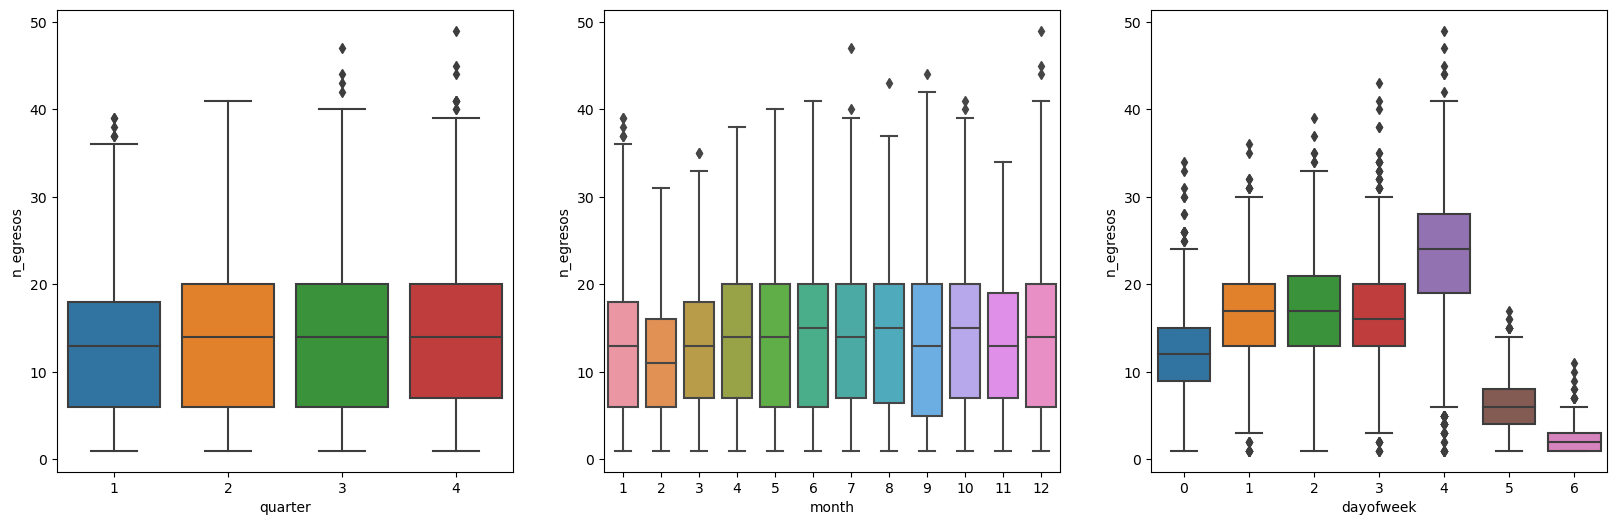

In [15]:
fig, axis = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(data=resumen_egresos, x="quarter", y="n_egresos", ax=axis[0])
sns.boxplot(data=resumen_egresos, x="month", y="n_egresos", ax=axis[1])
sns.boxplot(data=resumen_egresos, x="dayofweek", y="n_egresos", ax=axis[2])

Con estos resultados se puede observar que en el primer cuatrimestre existe una menor cantidad
de egresos hospitalarios. Ademas, se aprecia que la distribucion de egresos por mes es similar
a lo largo de cada mes. Sin embargo, es posible apreciar que en el mes de febrero existe una
baja en el promedio de egresos.

Dentro de una semana, se puede ver que la cantidad de egresos va aumentando durante la semana
laboral, teniendo un máximo los viernes. Además, se aprecia que los fin de semanas se tiene la
menor cantidad de egresos.


# 3. Creacion de Modelo


In [16]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [17]:
train = build_features.create_features_datetime_index(train)
test = build_features.create_features_datetime_index(test)

FEATURES = ["dayofweek", "quarter", "month", "year", "dayofyear"]
TARGET = "n_egresos"

In [18]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [19]:
reg = XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

In [20]:
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:15.65424	validation_1-rmse:15.08315
[100]	validation_0-rmse:7.37489	validation_1-rmse:7.89197


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

[200]	validation_0-rmse:5.22667	validation_1-rmse:6.26352
[300]	validation_0-rmse:4.75007	validation_1-rmse:6.04094
[400]	validation_0-rmse:4.57068	validation_1-rmse:6.01762
[463]	validation_0-rmse:4.50394	validation_1-rmse:6.01784


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importance


In [21]:
feature_importance = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"]
)

<Axes: >

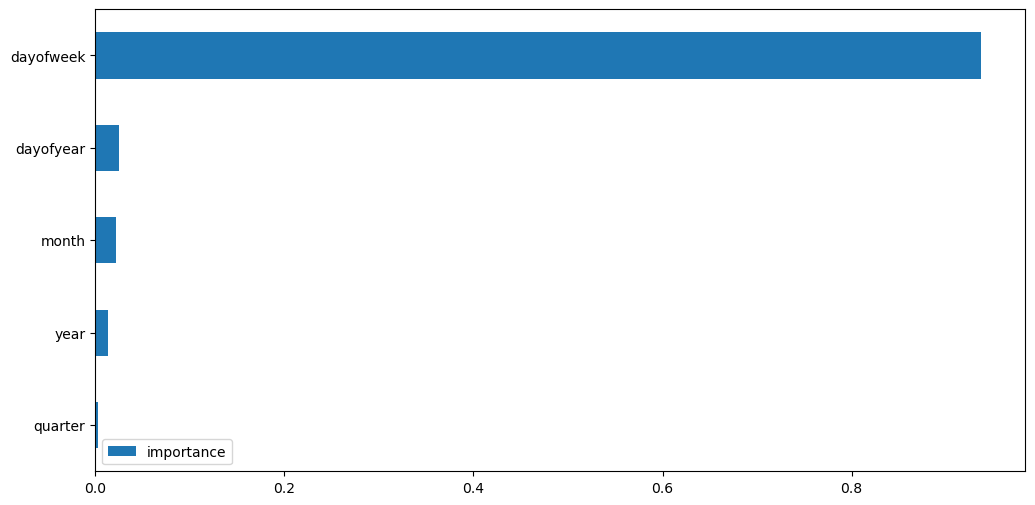

In [22]:
feature_importance.sort_values("importance").plot(kind="barh")

Estos resultados indican que el dia de la semana es altamente importante para predecir los egresos
hospitalarios!


## Prediccion en Test


In [23]:
test["prediction"] = reg.predict(X_test)

c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

In [24]:
resumen_egresos = resumen_egresos.merge(
    test["prediction"], how="left", left_index=True, right_index=True
)

Text(0.5, 1.0, 'Data Real vs Prediccion de Egresos Hospitalarios INT')

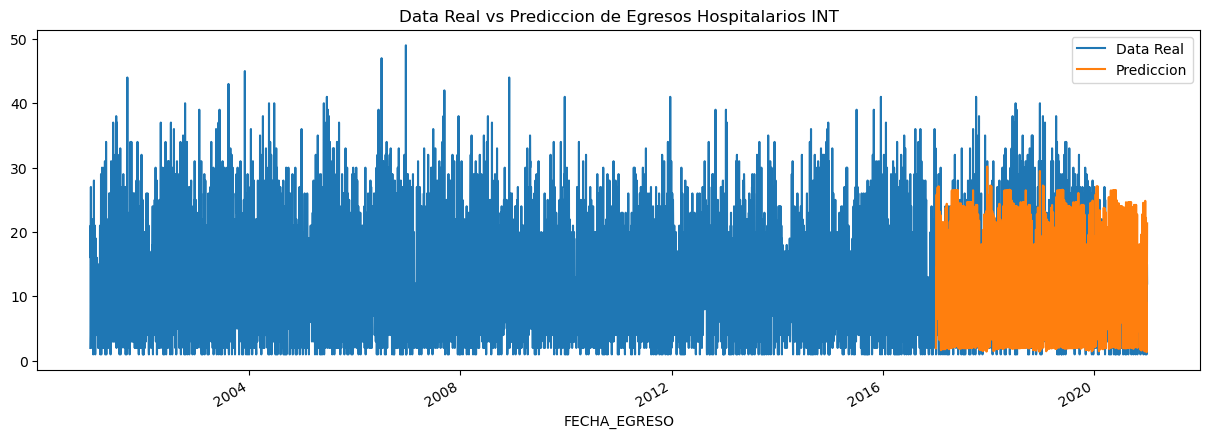

In [25]:
ax = resumen_egresos["n_egresos"].plot(figsize=(15, 5))
resumen_egresos["prediction"].plot(ax=ax)
plt.legend(["Data Real", "Prediccion"])
ax.set_title("Data Real vs Prediccion de Egresos Hospitalarios INT")

In [26]:
filtro_semana = resumen_egresos[
    (resumen_egresos.index >= "05-01-2017") & (resumen_egresos.index <= "07-01-2017")
]

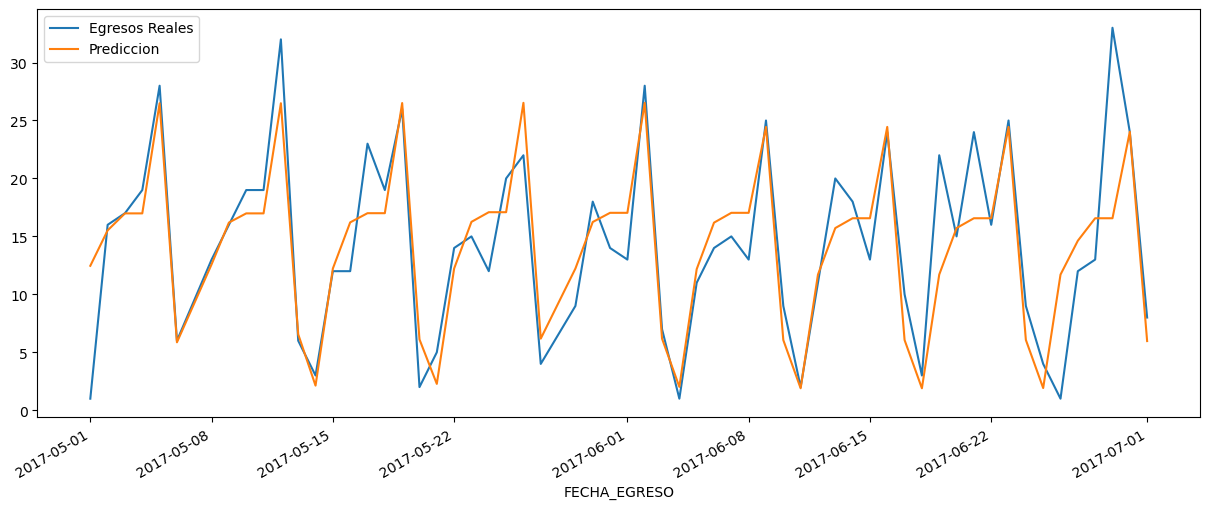

In [27]:
fig, axis = plt.subplots(figsize=(15, 6))
filtro_semana["n_egresos"].plot(ax=axis)
filtro_semana["prediction"].plot(ax=axis)
plt.legend(["Egresos Reales", "Prediccion"])

Y aca se puede ver la cantidad de egresos en la primera semana de Mayo de 2017.


In [28]:
rmse_modelo = np.sqrt(mean_squared_error(test["n_egresos"], test["prediction"]))
print(f"El modelo tiene un RMSE de: {rmse_modelo:0f} egresos")

El modelo tiene un RMSE de: 6.014391 egresos


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is depreca

In [29]:
test["error"] = np.abs(test["n_egresos"] - test["prediction"])

In [30]:
test.sort_values("error", ascending=False).head(5)

,n_egresos,dayofweek,quarter,month,year,dayofyear,lag_1_anio,lag_2_anios,lag_3_anios,prediction,error
FECHA_EGRESO,,,,,,,,,,,
2020-05-01,2,4,2,5,2020,122,23.0,19.0,28.0,26.419123,24.419123
2020-06-05,3,4,2,6,2020,157,32.0,33.0,25.0,24.913717,21.913717
2017-10-26,38,3,4,10,2017,299,NaN,NaN,NaN,16.164009,21.835991
2019-04-19,5,4,2,4,2019,109,32.0,14.0,NaN,26.463892,21.463892
2020-06-19,3,4,2,6,2020,171,34.0,30.0,25.0,24.445564,21.445564


In [31]:
test.sort_values("error", ascending=False).tail(5)

,n_egresos,dayofweek,quarter,month,year,dayofyear,lag_1_anio,lag_2_anios,lag_3_anios,prediction,error
FECHA_EGRESO,,,,,,,,,,,
2017-05-03,17,2,2,5,2017,123,NaN,NaN,NaN,16.986198,0.013802
2018-05-03,17,3,2,5,2018,123,19.0,NaN,NaN,16.986198,0.013802
2020-02-13,14,3,1,2,2020,44,16.0,22.0,15.0,13.989489,0.010511
2020-03-02,10,0,1,3,2020,62,15.0,10.0,9.0,10.007457,0.007457
2019-03-19,16,1,1,3,2019,78,12.0,18.0,NaN,16.003738,0.003738


<Axes: >

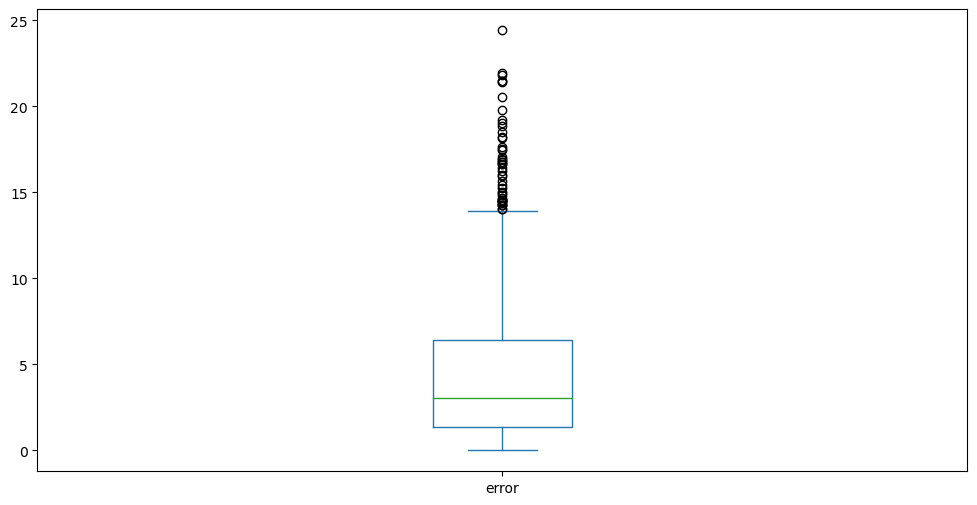

In [32]:
test["error"].plot(kind="box")

## Mejorando el modelo

Observamos que existen predicciones que tuvieron un error de hasta 26 egresos hospitalarios. Debido
a lo anterior, es necesario mejorar el modelo. Una de las formas mas efectivas de mejorar
el modelo es **remover outliers**!


## Remover Outliers

Se sabe que 2020 es un anio con grandes problemas (pandemia). Ademas, es posible observar una
disminucion significativa en la cantidad de egresos. Debido a esto, es necesario filtrar estos
anios.


In [33]:
resumen_egresos = resumen_egresos[resumen_egresos.index < "2020-01-01"]

Otra de las grandes mejores es hacer una validacion cruzada con las series de tiempo.


## Validacion Cruzada


In [34]:
from sklearn.model_selection import TimeSeriesSplit

In [35]:
tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=1)
resumen_egresos = resumen_egresos.sort_index()

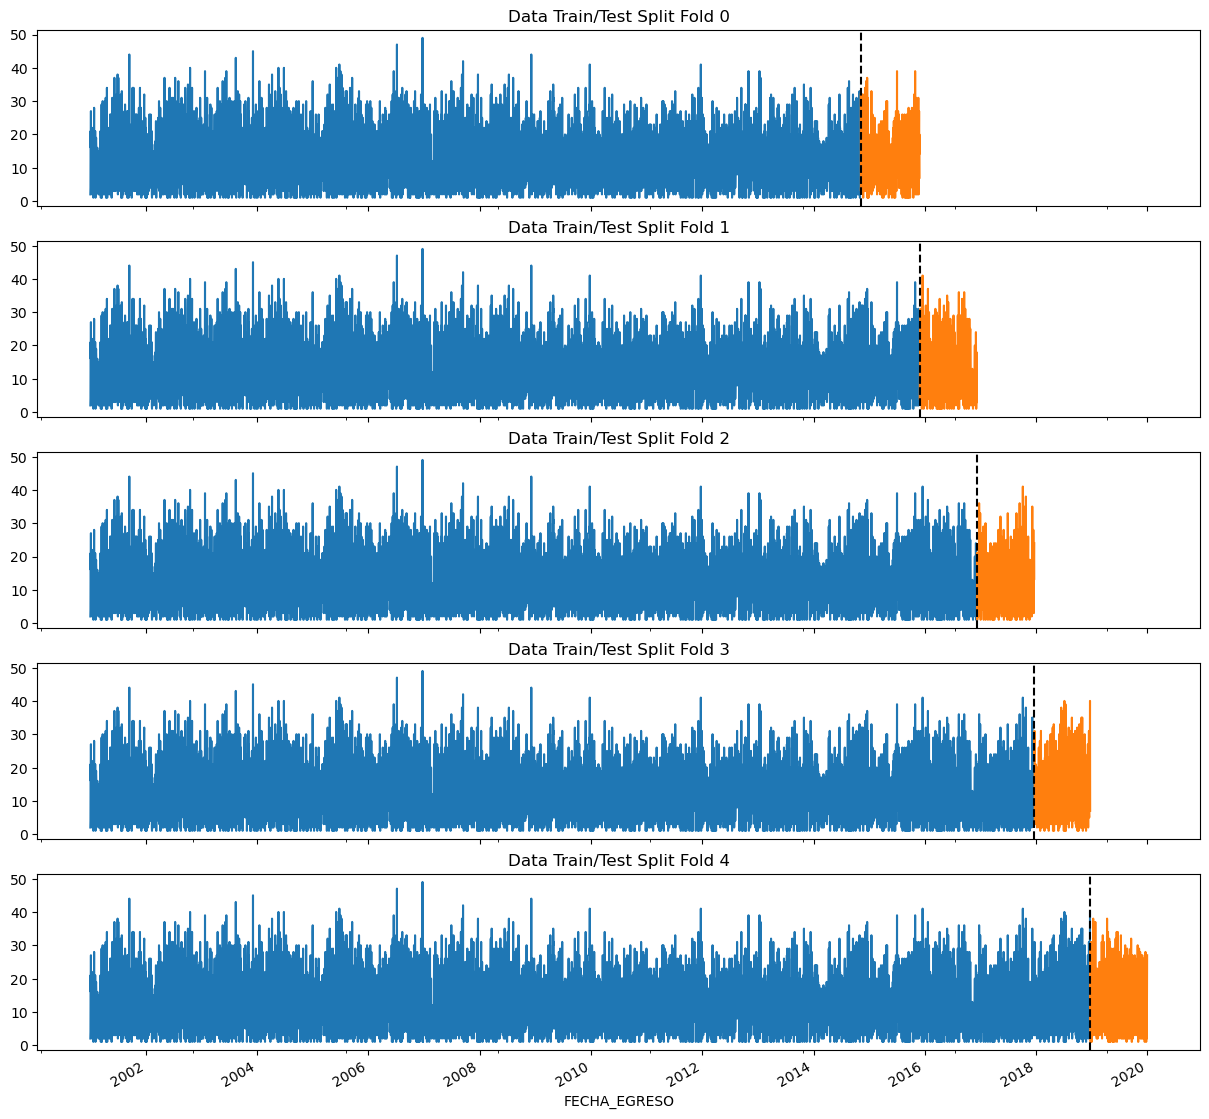

In [36]:
fig, axis = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(resumen_egresos):
    train = resumen_egresos.iloc[train_idx]
    test = resumen_egresos.iloc[val_idx]

    train["n_egresos"].plot(
        ax=axis[fold], label="Training", title=f"Data Train/Test Split Fold {fold}"
    )
    test["n_egresos"].plot(ax=axis[fold], label="Test Set")
    axis[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1

## Horizonte de Prediccion

Al final es asber cuantos anios se quiere predecir en el futuro. El nuevo hospital quiere
ser construido en 10 anios aproximadamente. Por lo tanto, el horizonte de prediccion es 10. Debido
a que es tan alejado, es normal que exista un mayor error.

Una forma de ver bien lo del horizonte es con las **lag features**.


## Lag Features

Son variables que indican el valores de egresos pero uno, dos, tres, etc... anios antes del
valor analizado.


In [37]:
resumen_egresos = build_features.add_lag_features(resumen_egresos)

In [38]:
resumen_egresos.tail()

,n_egresos,dayofweek,quarter,month,year,dayofyear,lag_1_anio,lag_2_anios,lag_3_anios,prediction
FECHA_EGRESO,,,,,,,,,,
2019-12-27,24,4,4,12,2019,361,31.0,21.0,33.0,18.414816
2019-12-28,7,5,4,12,2019,362,2.0,16.0,9.0,5.207456
2019-12-29,2,6,4,12,2019,363,11.0,3.0,4.0,2.528246
2019-12-30,12,0,4,12,2019,364,21.0,NaN,1.0,14.452960
2019-12-31,27,1,4,12,2019,365,1.0,7.0,4.0,15.285486


## Entrenar con Validacion Cruzada


In [39]:
tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=20)
resumen_egresos = resumen_egresos.sort_index()

In [40]:
fold = 0
predicciones = []
scores = []

for train_idx, valid_idx in tss.split(resumen_egresos):
    train = resumen_egresos.iloc[train_idx]
    test = resumen_egresos.iloc[valid_idx]

    train = build_features.create_features_datetime_index(train)
    test = build_features.create_features_datetime_index(test)

    FEATURES = [
        "dayofweek",
        "quarter",
        "month",
        "year",
        "dayofyear",
        "lag_1_anio",
        "lag_2_anios",
        "lag_3_anios",
    ]

    TARGET = "n_egresos"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        n_estimators=1000,
        objective="reg:squarederror",
        early_stopping_round=500,
        max_depth=3,
        learning_rate=0.01,
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

    y_pred = reg.predict(X_test)
    predicciones.append(y_pred)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(rmse)

[09:25:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[0]	validation_0-rmse:15.67558	validation_1-rmse:15.31246
[100]	validation_0-rmse:7.59699	validation_1-rmse:7.28107
[200]	validation_0-rmse:5.57429	validation_1-rmse:5.63545


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

[300]	validation_0-rmse:5.15127	validation_1-rmse:5.31016
[400]	validation_0-rmse:5.01962	validation_1-rmse:5.23802
[500]	validation_0-rmse:4.93435	validation_1-rmse:5.18764
[600]	validation_0-rmse:4.87678	validation_1-rmse:5.13349
[700]	validation_0-rmse:4.83570	validation_1-rmse:5.09928
[800]	validation_0-rmse:4.79540	validation_1-rmse:5.06076
[900]	validation_0-rmse:4.75887	validation_1-rmse:5.02020
[999]	validation_0-rmse:4.73171	validation_1-rmse:4.99359
[09:25:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[0]	validation_0-rmse:15.64609	validation_1-rmse:15.70846
[100]	validation_0-rmse:7.59076	validation_1-rmse:7.71946


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

[200]	validation_0-rmse:5.58033	validation_1-rmse:5.99660
[300]	validation_0-rmse:5.15938	validation_1-rmse:5.62712
[400]	validation_0-rmse:5.03907	validation_1-rmse:5.54130
[500]	validation_0-rmse:4.96515	validation_1-rmse:5.49596
[600]	validation_0-rmse:4.90150	validation_1-rmse:5.45323
[700]	validation_0-rmse:4.85663	validation_1-rmse:5.43044
[800]	validation_0-rmse:4.80856	validation_1-rmse:5.41026
[900]	validation_0-rmse:4.77533	validation_1-rmse:5.41850
[999]	validation_0-rmse:4.74527	validation_1-rmse:5.42939
[09:25:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[0]	validation_0-rmse:15.66429	validation_1-rmse:15.55493
[100]	validation_0-rmse:7.59468	validation_1-rmse:7.28327


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

[200]	validation_0-rmse:5.58846	validation_1-rmse:5.39406
[300]	validation_0-rmse:5.17327	validation_1-rmse:5.00455
[400]	validation_0-rmse:5.05337	validation_1-rmse:4.88732
[500]	validation_0-rmse:4.96693	validation_1-rmse:4.84758
[600]	validation_0-rmse:4.90088	validation_1-rmse:4.82105
[700]	validation_0-rmse:4.85919	validation_1-rmse:4.82672
[800]	validation_0-rmse:4.81160	validation_1-rmse:4.82394
[900]	validation_0-rmse:4.78154	validation_1-rmse:4.82422
[999]	validation_0-rmse:4.75451	validation_1-rmse:4.84060
[09:25:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[0]	validation_0-rmse:15.64149	validation_1-rmse:16.90583
[100]	validation_0-rmse:7.56829	validation_1-rmse:8.47961


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

[200]	validation_0-rmse:5.56071	validation_1-rmse:6.29106
[300]	validation_0-rmse:5.14727	validation_1-rmse:5.68194
[400]	validation_0-rmse:5.02728	validation_1-rmse:5.50583
[500]	validation_0-rmse:4.94649	validation_1-rmse:5.37485
[600]	validation_0-rmse:4.87916	validation_1-rmse:5.28268
[700]	validation_0-rmse:4.83982	validation_1-rmse:5.23970
[800]	validation_0-rmse:4.79952	validation_1-rmse:5.21155
[900]	validation_0-rmse:4.76790	validation_1-rmse:5.19037
[999]	validation_0-rmse:4.74026	validation_1-rmse:5.17587
[09:25:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[0]	validation_0-rmse:15.70570	validation_1-rmse:17.08258
[100]	validation_0-rmse:7.58561	validation_1-rmse:8.64143


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

[200]	validation_0-rmse:5.57136	validation_1-rmse:6.46883
[300]	validation_0-rmse:5.15769	validation_1-rmse:5.87978
[400]	validation_0-rmse:5.02578	validation_1-rmse:5.71018
[500]	validation_0-rmse:4.94826	validation_1-rmse:5.58005
[600]	validation_0-rmse:4.89729	validation_1-rmse:5.51772
[700]	validation_0-rmse:4.85581	validation_1-rmse:5.47282
[800]	validation_0-rmse:4.81904	validation_1-rmse:5.44666
[900]	validation_0-rmse:4.78727	validation_1-rmse:5.44731
[999]	validation_0-rmse:4.75321	validation_1-rmse:5.42315


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

In [41]:
print(f"El RMSE promedio entre los 5 folds es: {np.mean(scores):.2f}")
print(f"Los scores de los folds fueron: {scores}")

El RMSE promedio entre los 5 folds es: 5.17
Los scores de los folds fueron: [4.993593261723502, 5.429390086809824, 4.840600387162541, 5.175872395152558, 5.42315418066935]


Por lo tanto, el modelo tiene un error promedio de 5 egresos.

Una vez que ya vimos cuanto error tienen los modelos, es necesario entrenar un modelo con toda
la data para hacer predicciones en el futuro.


In [42]:
# Reentrena en toda la data, exceptuando con 2020
resumen_egresos = build_features.create_features_datetime_index(resumen_egresos)

In [43]:
FEATURES = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "lag_1_anio",
    "lag_2_anios",
    "lag_3_anios",
]

TARGET = "n_egresos"

X_all = resumen_egresos[FEATURES]
y_all = resumen_egresos[TARGET]

reg = XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    n_estimators=1000,
    objective="reg:squarederror",
    max_depth=3,
    learning_rate=0.01,
)

reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[0]	validation_0-rmse:15.79649
[100]	validation_0-rmse:7.62090
[200]	validation_0-rmse:5.59499


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

[300]	validation_0-rmse:5.17334
[400]	validation_0-rmse:5.04234
[500]	validation_0-rmse:4.96896
[600]	validation_0-rmse:4.91642
[700]	validation_0-rmse:4.87781
[800]	validation_0-rmse:4.83378
[900]	validation_0-rmse:4.79739
[999]	validation_0-rmse:4.76297


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Predecir en el futuro


In [44]:
# Crear DataFrame del futuro
futuro = pd.date_range("2019-12-31", "2030-12-31")
df_futuro = pd.DataFrame(index=futuro)
df_futuro["es_futuro"] = True
resumen_egresos["es_futuro"] = False

resumen_egresos_y_futuro = pd.concat([resumen_egresos, df_futuro])

In [45]:
resumen_egresos_y_futuro = build_features.create_features_datetime_index(resumen_egresos_y_futuro)
futuro_con_features = resumen_egresos_y_futuro.query("es_futuro == True")

## Predecir como tal


In [46]:
futuro_con_features["prediction"] = reg.predict(futuro_con_features[FEATURES])

c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

<Axes: >

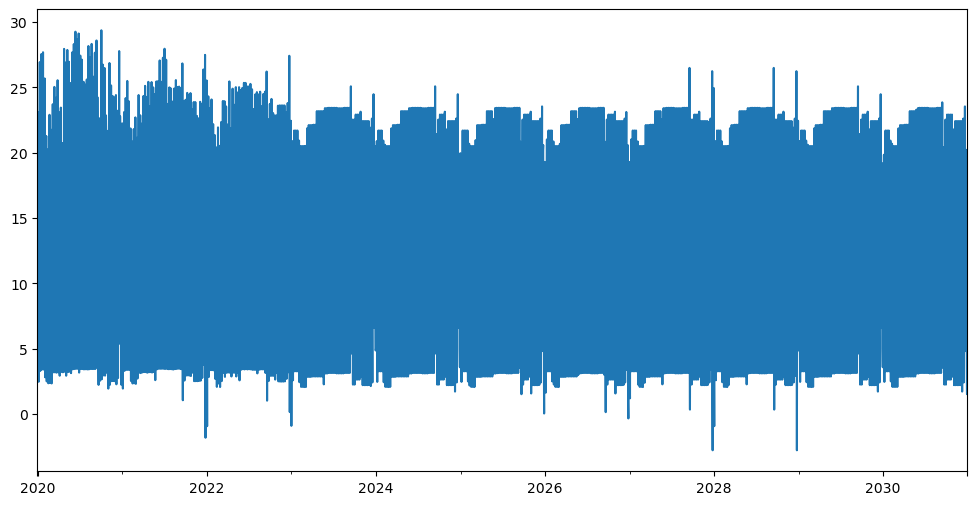

In [47]:
futuro_con_features["prediction"].plot()

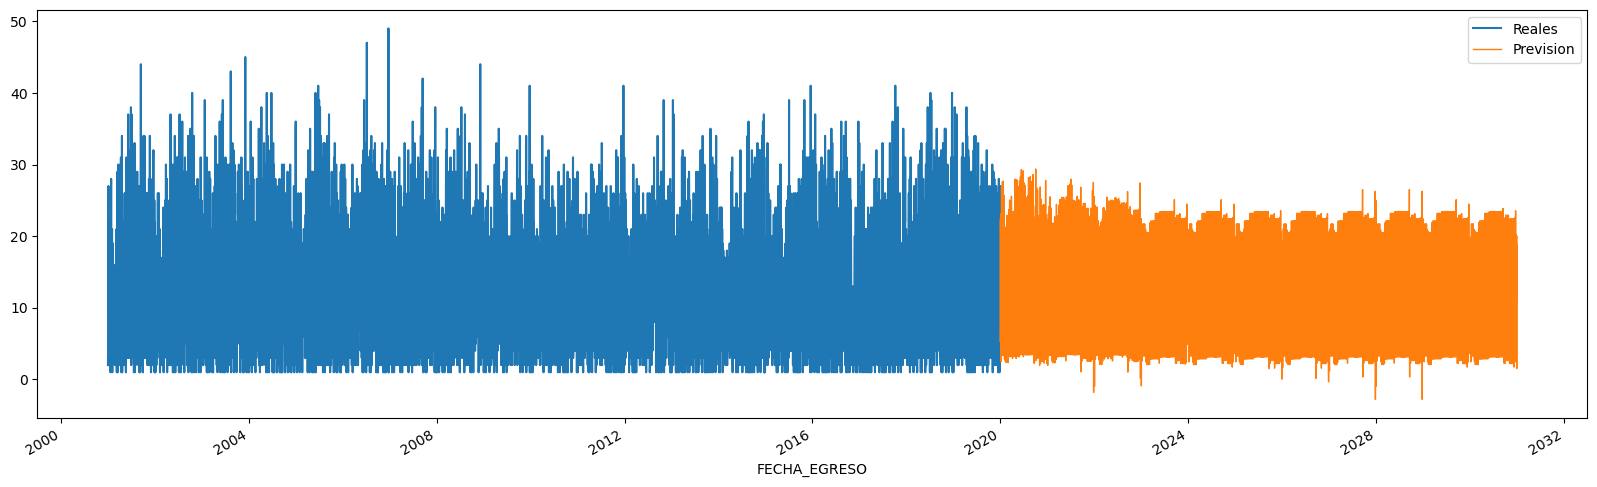

In [48]:
fig, axis = plt.subplots(1, 1, figsize=(20, 6))
resumen_egresos["n_egresos"].plot(ax=axis, label="Reales")
futuro_con_features["prediction"].plot(ax=axis, ms=1, lw=1, label="Prevision")
plt.legend()

# 2. Predicción de Insumos necesarios para el Hospital

En este apartado se quiere hacer una predicción de los insumos necesarios para el nuevo hospital,
teniendo en cuenta la demanda vista entre los años 2019, 2020 y 2021.


In [3]:
RUTA_ARCHIVO = "../data/processed/conteo_procedimientos_por_dia_int.csv"
procedimientos_hospitalizados = pd.read_csv(RUTA_ARCHIVO)
procedimientos_hospitalizados["FECHAALTA"] = pd.to_datetime(
    procedimientos_hospitalizados["FECHAALTA"]
)

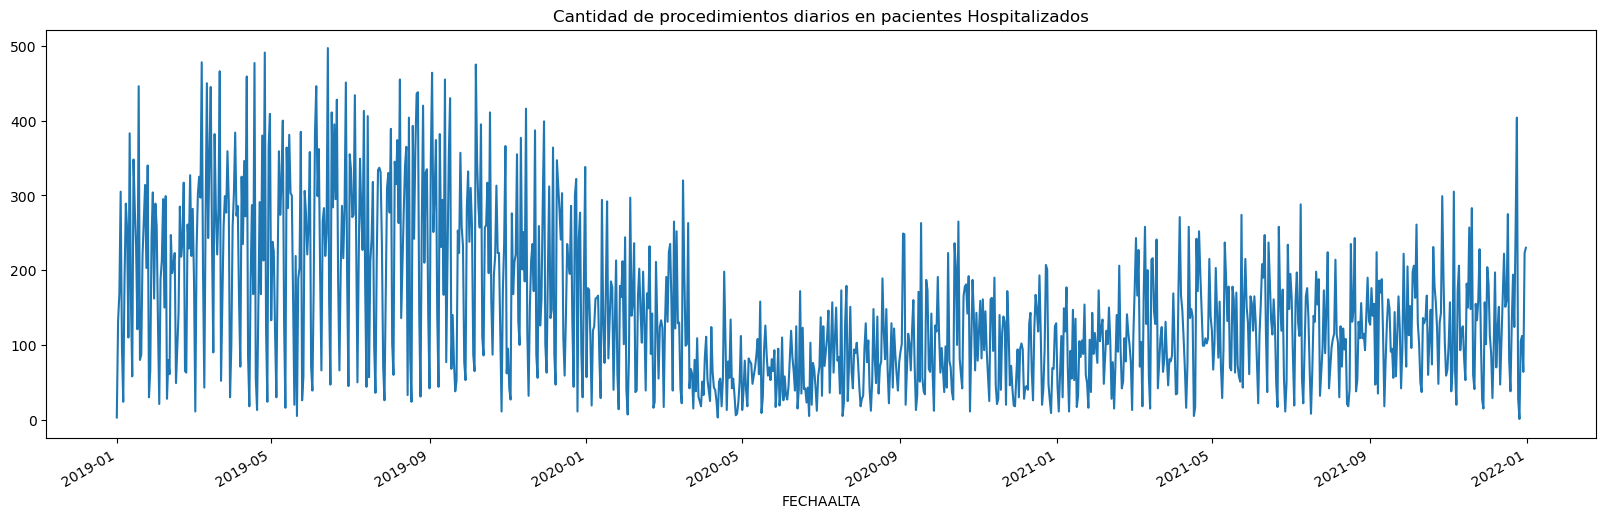

In [4]:
axis = (
    procedimientos_hospitalizados.groupby(procedimientos_hospitalizados["FECHAALTA"])["count"]
    .sum()
    .plot(title="Cantidad de procedimientos diarios en pacientes Hospitalizados", figsize=(20, 6))
)

In [25]:
df_proc = (
    procedimientos_hospitalizados.groupby(["FECHAALTA", "DIAGNOSTICO1", "procedimiento"])["count"]
    .sum()
    .reset_index(level=[1, 2])
)

df_proc = build_features.create_features_datetime_index(df_proc)

c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: 

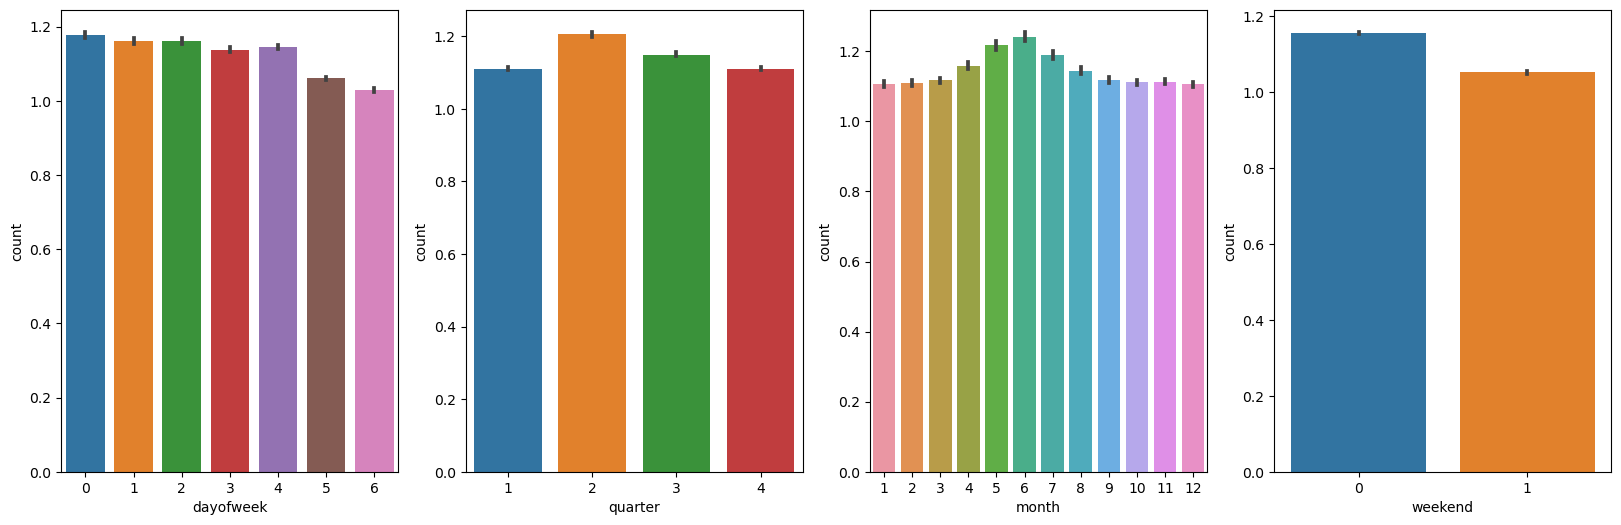

In [30]:
variables_temporales = ["dayofweek", "quarter", "month", "weekend"]

fig, axis = plt.subplots(1, 4, figsize=(20, 6))
for i, variable in enumerate(variables_temporales):
    sns.barplot(data=df_proc, x=variable, y="count", ax=axis[i])

Los resultados indican lo siguiente:

- Durante la semana, la cantidad de procedimientos realizados disminuye a lo largo de la semana,
teniendo una máxima los Lunes (0) y un mínimo los Domingos (6)

- Dentro de los cuatrimestres, se ve que el segundo cuatrimestre es en donde se realizan la mayor
cantidad de procedimientos.

- Dentro de los meses, se observa que Abril, Mayo, Junio (máximo), Julio y Agosto tienen la mayor
demanda de procedimientos.

- Se observa una mayor demanda en la semana que en los fin de semana.